In [1]:
import numpy as np
from tqdm.auto import trange
from sklearn.linear_model import LogisticRegression
from utils.metric import evaluate, eval_safety
from utils.func import read_jsonl, softmax
from utils.store_data import ReadData
from sklearn.model_selection import train_test_split
from ml_utils.semantic_entropy import best_split,binarize_entropy
from sklearn.metrics import accuracy_score
from dataset.MMSafety import AnswerChecker
import random

### Load Data

In [2]:
data=np.load('./output/results_trivia_qa.npy',allow_pickle=True)

In [3]:
i=36

print(data[i].keys())

print(data[i]['most_likely']['response'])
print(data[i]['most_likely']['correctness'])
#print(data[i]['is_safe'])
print(data[i]['most_likely']['embedding'].shape)

print(data[i]['responses'])
print(data[i]['question'])
print(data[i]['answers'])
print(data[i]['entropy'])

dict_keys(['id', 'question', 'context', 'answers', 'most_likely', 'responses', 'entropy'])
olga korbut
0.0
(33, 1, 4096)
['olga korbut', 'lynn marshall', 'olga korbut', '', 'olga korbut.', 'gabriele reinsch', 'nadia comaneci', '', 'ivalka demesyk', '']
Answer the following question as briefly as possible.
Question: In April, which sportsman married his childhood sweetheart Kim Sears?
Answer: andy murray

Question: From the Latin for argentum, which element, with an atomic number of 47, uses the symbol Ag?
Answer: silver

Question: In which English city will you find the Ashmolean museum?
Answer: oxford

Question: In which city was John Lennon murdered?
Answer: new york

Question: How many basic positions are there in classical ballet?
Answer: five

Question: In 1976 who was the first gymnast to score a perfect ten in Olympic competition?
Answer: 
['comaneci']
1.6434177197931796


### Split train and test sets

In [4]:
train_size=0.8

In [5]:
# Shuffle the list to ensure randomness
random.shuffle(data)

# Calculate split indices
split_point = int(len(data) * train_size)

# Split the list
data_train = data[:split_point]
data_test = data[split_point:]

In [6]:
len(data_train),len(data_test)

(160, 40)

### Construct numpy data for training

In [7]:
embedding_layer=30 # the embedding layer used for classification

In [8]:
X_train=np.array([x['most_likely']['embedding'][embedding_layer].squeeze() for x in data_train])
y_train=np.array([x['entropy'] for x in data_train])

X_test=np.array([x['most_likely']['embedding'][embedding_layer].squeeze() for x in data_test])
y_correct_test=np.array([x['most_likely']['correctness'] for x in data_test]) # wheather the answer that LLM generated is correct
#y_ground_test=np.array([x['is_safe'] for x in data_test]) # ground truth

all_entropy=np.array([x['entropy'] for x in data])

In [9]:
all_entropy

array([-0.        ,  1.22752941, -0.        ,  0.94334839, -0.        ,
       -0.        ,  0.32508297,  0.63903186,  0.80181855,  2.02532622,
        0.94044799, -0.        ,  1.08889998,  0.63903186, -0.        ,
        0.32508297,  1.02965301,  1.97300141, -0.        ,  1.83437197,
        0.80181855,  0.32508297, -0.        ,  1.97300141,  0.32508297,
        0.6108643 ,  0.6108643 ,  1.74806735, -0.        , -0.        ,
        0.89794572,  0.32508297,  0.32508297, -0.        ,  0.50040242,
        1.83437197, -0.        , -0.        ,  0.6108643 ,  0.6108643 ,
        1.83437197,  0.80181855, -0.        ,  1.1935496 ,  1.3592367 ,
        0.32508297,  0.32508297,  0.32508297,  1.16828245, -0.        ,
       -0.        , -0.        ,  1.22060726,  1.50478828,  0.32508297,
        1.41848366, -0.        , -0.        ,  2.02532622, -0.        ,
        1.08889998,  0.32508297, -0.        ,  1.83437197, -0.        ,
        0.89794572,  0.63903186,  0.32508297, -0.        , -0.  

In [10]:
X_train.shape,y_train.shape,X_test.shape,y_correct_test.shape

((160, 4096), (160,), (40, 4096), (40,))

### Convert entropies to labels

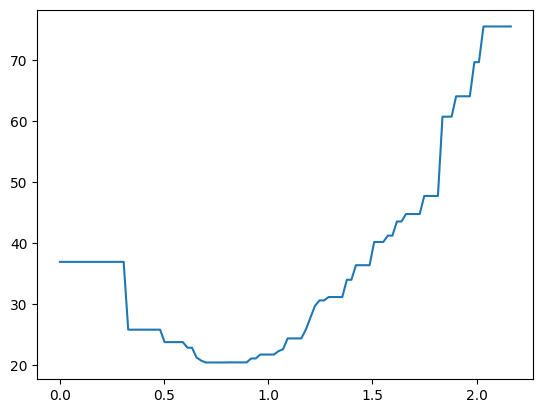

In [11]:
entropy_split=best_split(all_entropy, "All datasets collective")
y_train=binarize_entropy(y_train, entropy_split)

### Train Linear Prob

In [12]:
y_train

array([0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1.,
       1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
       0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0.,
       1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1.,
       1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1.,
       0., 0., 1., 1., 0., 1., 1.], dtype=float32)

In [13]:
X_train

array([[-0.47851562, -0.91015625,  1.4765625 , ...,  1.9921875 ,
         0.7734375 , -0.42382812],
       [-0.0234375 ,  0.77734375,  1.390625  , ..., -0.19921875,
        -1.3828125 ,  0.19726562],
       [ 0.28515625,  1.3984375 ,  0.5       , ...,  0.30078125,
        -0.21679688, -0.37109375],
       ...,
       [-1.6328125 ,  0.2734375 , -0.17578125, ...,  1.7109375 ,
         0.01757812,  0.28515625],
       [ 0.33007812,  0.25390625,  0.9609375 , ...,  2.140625  ,
         0.640625  , -2.734375  ],
       [ 0.38085938,  0.52734375,  1.796875  , ...,  0.265625  ,
        -1.40625   ,  0.140625  ]], dtype=float32)

In [14]:
model = LogisticRegression()

model.fit(X_train,y_train)

LogisticRegression()

### View results on train and test sets

In [15]:
X_test.shape

(40, 4096)

In [16]:
X_test[y_correct_test==1].shape,X_test[y_correct_test==0].shape

((18, 4096), (22, 4096))

In [ ]:
y_test_pred=model.predict(X_test)


Accuracy: 75.00%


In [18]:
y_test_pred

array([0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0.,
       1., 1., 0., 0., 1., 0.], dtype=float32)

In [ ]:
y_correct_test

array([0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0.,
       1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 1., 0., 1., 1., 1.])

In [ ]:
accuracy = accuracy_score(1-y_correct_test, y_test_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 75.00%
